In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from saxs_data_processing import io
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import json
from matplotlib.backends.backend_pdf import PdfPages

import sys
sys.path.append('../../silica_opt_insilico/src/silica_opt_insilico/')
import pd_utils
import matplotlib.ticker as ticker

## Load constants and filepaths

In [3]:
with open('../APS/Mesoporous_constants_APS_batch.json', 'rt') as f:
    constants = json.load(f)

In [4]:
data_fp = "/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/APS_Beamtime_Sp25/BatchSamplesData/Reduced_ascii_4_18_25_emptyBlank_renamed"

In [5]:
paths = os.listdir(data_fp)

In [6]:
# load usaxs data

In [7]:
sample_table = pd.read_csv("/mnt/c/Users/bgpel/My Drive/Research/PozzoResearchGroup/APS_Beamtime_Sp25/APS_sample_reference_cartridgebatch.csv")

In [8]:
composition_table = pd.read_csv('../APS/Mesoporous_SobolBaseline_APS_BatchMode_3_29_25.csv').set_index('uuid', drop=True)

In [9]:
def get_composition(row, teos_dilution_ratio, ctab_concentration, f127_concentration):
    teos_volume = row['teos_volume']
    ammonia_volume = row['ammonia_volume']
    water_volume = row['water_volume']
    ethanol_volume = row['ethanol_volume']
    ctab_volume = row['ctab_volume']
    F127_volume = row['F127_volume']

    total_volume = teos_volume + ammonia_volume + water_volume + ethanol_volume + ctab_volume + F127_volume
    print('Total volume: ', total_volume)
    
    ammonia_vf = ammonia_volume/total_volume
    water_delivered_vf = water_volume / total_volume
    ethanol_delivered_vf = ethanol_volume/total_volume
    ctab_vf = ctab_volume/total_volume
    F127_vf = F127_volume/total_volume


    ## Need to correct for mixed compositions

    # TEOS and ethanol:
    teos_vf = teos_volume/teos_dilution_ratio/total_volume
    teos_etoh_vf = teos_volume*((teos_dilution_ratio - 1)/teos_dilution_ratio)/total_volume

    ethanol_vf = ethanol_delivered_vf + teos_etoh_vf

    print('Ethanol delivered vf: ', ethanol_delivered_vf)
    print('Ethanol TEOS vf: ', teos_etoh_vf)
    print('Total ethanol vf: ', ethanol_vf)

    

    water_vf = water_delivered_vf + F127_vf + ctab_vf

    ctab_mass = ctab_volume * ctab_concentration
    f127_mass = F127_volume * f127_concentration

    # 

    return {'teos_vf':teos_vf, 'ammonia_vf':ammonia_vf, 'water_vf':water_vf, 'ethanol_vf':ethanol_vf, 'ctab_mass':ctab_mass, 'F127_mass':f127_mass}

In [10]:
def get_filename(stub, paths):
    for path in paths:
        if stub in path:
            return path

In [11]:
sobolbatch_samples = {}
teos_dilution_ratio = constants['TEOS']['dilution_ratio']
ctab_concentration = constants['ctab']['stock_concentration_mg_uL']
f127_concentration = constants['f127']['stock_concentration_mg_uL']

for i, row in sample_table.iloc[0:73].iterrows():
    sample = {}
    sample['sample_name'] = row['Sample name']
    sample['cartridge_number'] = row['Cartridge plate']
    sample['cartridge_cell'] = row['Cartridge cell']
    sample_uid = row['Sample ID']

    plate_id = '0_c2' if row['Cartridge plate'] == 2.0 else '1'

    filename_stub = f'{row['Cartridge cell']}_{plate_id}'

    if sample_uid is not np.nan:
        
        filename = get_filename(filename_stub, paths)
        print(filename)
        sample['data'] = pd.read_csv(data_fp+'/'+filename, sep = '\t')


        composition_row = composition_table.loc[sample_uid]
        composition = get_composition(composition_row, teos_dilution_ratio, ctab_concentration, f127_concentration)
        sample['composition'] = composition
        sobolbatch_samples[sample_uid] = sample


        


        
    

2_5dfdbe5e-3f38-44de-b9db-65c72c27f02e_A3_1_2036.dat
Total volume:  9999.999992000001
Ethanol delivered vf:  0.2721331681177065
Ethanol TEOS vf:  0.03215435182396909
Total ethanol vf:  0.3042875199416756
3_93780a39-35f5-4c85-963b-2fde66396c78_A4_1_2037.dat
Total volume:  9999.999992000001
Ethanol delivered vf:  0.2721331681177065
Ethanol TEOS vf:  0.03215435182396909
Total ethanol vf:  0.3042875199416756
4_00afc63f-86d3-41a0-9f37-8d56c6d1abfd_A5_1_2038.dat
Total volume:  9999.999992000001
Ethanol delivered vf:  0.2721331681177065
Ethanol TEOS vf:  0.03215435182396909
Total ethanol vf:  0.3042875199416756
5_83caa81b-c9ac-4b2f-b7b6-97a05c42f277_A6_1_2039.dat
Total volume:  10000.0
Ethanol delivered vf:  0.2101010853994405
Ethanol TEOS vf:  0.053794442619034086
Total ethanol vf:  0.2638955280184746
6_285271f3-055d-4edd-9cdd-3322ed1140ed_A7_1_2040.dat
Total volume:  9999.999999999998
Ethanol delivered vf:  0.1553807337944862
Ethanol TEOS vf:  0.04799717765399256
Total ethanol vf:  0.203377

## Plot scattering

In [12]:
### Plot the one nice one

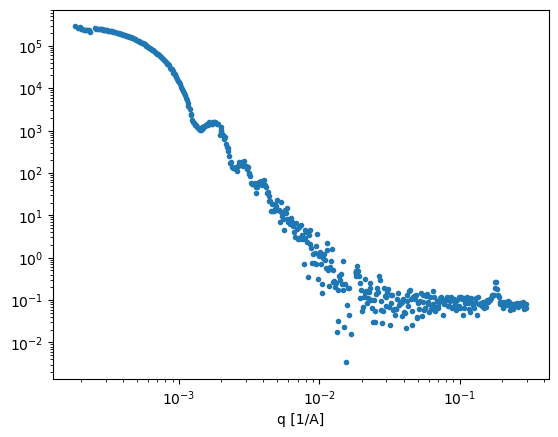

In [13]:
for sample in sobolbatch_samples.values():
    if sample['sample_name'] == 'SobolBatch_43':
        fig, ax = plt.subplots()
        q = sample['data']['Qvector_A']
        I = sample['data']['Intensity']
        ax.loglog(q, I, ls = '', marker = '.')

        ax.set_xlabel('q [1/A]')
        #ax.set_title(sample['sample_name'])
        plt.savefig('sample43.png', dpi = 300)
    

## Make phase plots

In [14]:
# color code by classification
monodisperse_dispersion = [
                            5,
                            11,
                            18,
                            19,
                            21,
                            25,
                            27,
                            35,
                            43,
                            62,
]

monodisperse_aggregates = [6,
                           7,  
                           8,  
                           28,  
                           32,  
                           34,  
                           36,  
                           44,  
                           50,  
                           52,  
                           55,  
                           63,
                        ]

polydisperse_dispersion = [
                            'control_1',  
                            'control_2',  
                            'control_3',  
                            4,  
                            12,  
                            15,  
                            16,  
                            20,  
                            22,  
                            24,  
                            'control_4',  
                            31,  
                            33,  
                            37,  
                            41,
]

polydisperse_aggregates = [9,  
                            10,  
                            14,  
                            17,  
                            23,  
                            26,  
                            30,  
                            38,  
                            48,  
                            "control_5",  
                            53,  
                            54,  
                            56,  
                            57,  
                            58,  
                            59,  
                            61
                          ]

other = [
        1,
        2,  
        3,  
        13,  
        29,  
        39,  
        40,  
        42,  
        45,  
        46,  
        47,  
        51,  
        60
]


In [15]:
sample_table.iloc[0:10]

,Sample name,Sample ID,Vial number,Box location,Cartridge plate,Cartridge cell,Loaded?
0,Water blank,NaN,NaN,NaN,1.0,A1,y
1,Empty cell blank,NaN,NaN,NaN,1.0,A2,y
2,SobolBatch_control_1,5dfdbe5e-3f38-44de-b9db-65c72c27f02e,5,A1,1.0,A3,y
3,SobolBatch_control_2,93780a39-35f5-4c85-963b-2fde66396c78,7,A2,1.0,A4,y
4,SobolBatch_control_3,00afc63f-86d3-41a0-9f37-8d56c6d1abfd,9,A3,1.0,A5,y
5,SobolBatch_1,83caa81b-c9ac-4b2f-b7b6-97a05c42f277,10,A4,1.0,A6,y
6,SobolBatch_2,285271f3-055d-4edd-9cdd-3322ed1140ed,11,A5,1.0,A7,y
7,SobolBatch_3,8f86f557-5b97-4a80-b8da-55a55056d4b5,12,A6,1.0,A8,y
8,SobolBatch_4,0491adba-e277-4475-aee0-af111005fd40,24,A7,1.0,B1,y
9,SobolBatch_5,586e06c8-0f02-43a3-9f2f-81e46d43ef64,23,A8,1.0,B2,y


In [16]:
def get_colormap_color_monodispersity(name, monodisperse_dispersion, monodisperse_aggregates, polydisperse_dispersion, polydisperse_aggregates, other):
    if 'control' in name:
        namestub = '_'.join(name.split('_')[1:])
        for entry in monodisperse_dispersion:
            if entry == namestub:
                return 'red'
        for entry in monodisperse_aggregates:
            if entry == namestub:
                return 'red'
        for entry in polydisperse_dispersion:
            if entry == namestub:
                return 'blue'
        for entry in polydisperse_aggregates:
            if entry == namestub:
                return 'blue'
        for entry in other:
            if entry == namestub:
                return 'gray'

    else:
        num = int(name.split('_')[-1])
        for entry in monodisperse_dispersion:
            if eval_match(num, entry):
                return 'red'
        for entry in monodisperse_aggregates:
            if eval_match(num, entry):
                return 'red'
        for entry in polydisperse_dispersion:
            if eval_match(num, entry):
                return 'blue'
        for entry in polydisperse_aggregates:
            if eval_match(num, entry):
                return 'blue'
        for entry in other:
            if eval_match(num, entry):
                return 'gray'
                
    print('no match found')

def get_colormap_color_aggregates(name, monodisperse_dispersion, monodisperse_aggregates, polydisperse_dispersion, polydisperse_aggregates, other):
    if 'control' in name:
        namestub = '_'.join(name.split('_')[1:])
        for entry in monodisperse_dispersion:
            if entry == namestub:
                return 'orange'
        for entry in monodisperse_aggregates:
            if entry == namestub:
                return 'green'
        for entry in polydisperse_dispersion:
            if entry == namestub:
                return 'orange'
        for entry in polydisperse_aggregates:
            if entry == namestub:
                return 'green'
        for entry in other:
            if entry == namestub:
                return 'gray'

    else:
        num = int(name.split('_')[-1])
        for entry in monodisperse_dispersion:
            if eval_match(num, entry):
                return 'orange'
        for entry in monodisperse_aggregates:
            if eval_match(num, entry):
                return 'green'
        for entry in polydisperse_dispersion:
            if eval_match(num, entry):
                return 'orange'
        for entry in polydisperse_aggregates:
            if eval_match(num, entry):
                return 'green'
        for entry in other:
            if eval_match(num, entry):
                return 'gray'
                
    print('no match found')

def eval_match(num, entry):
    if isinstance(entry, str):
        return False
    elif num == entry:
        return True
    else:
        return False

In [17]:
ctab_min_vf = constants['ctab']['minimum_mass']/constants['ctab']['stock_concentration_mg_uL']/10000
ctab_max_vf = constants['ctab']['maximum_mass']/constants['ctab']['stock_concentration_mg_uL']/10000

In [18]:
f127_min_vf = constants['f127']['minimum_mass']/constants['f127']['stock_concentration_mg_uL']/10000
f127_max_vf = constants['f127']['maximum_mass']/constants['f127']['stock_concentration_mg_uL']/10000

In [19]:
lower_bounds = [constants['TEOS']['minimum_volume_fraction'],
                constants['ammonia']['minimum_volume_fraction'],
                constants['ethanol']['minimum_volume_fraction'],
                constants['ctab']['minimum_mass'],
                constants['f127']['minimum_mass'],
                constants['water']['minimum_volume_fraction']]

upper_bounds = [constants['TEOS']['maximum_volume_fraction'],
                constants['ammonia']['maximum_volume_fraction'],
                constants['ethanol']['maximum_volume_fraction'],
                constants['ctab']['maximum_mass'],
                constants['f127']['maximum_mass'],
                constants['water']['maximum_volume_fraction']]

In [20]:
inset_kwargs = {'lw':1}

In [29]:
from matplotlib.ticker import FuncFormatter
def format_func_0(x, _):
    return f'{x:.2f}'

def format_func(x, _):
    return f'{x:.2f}'

no match found
no match found
<function plot_phasemap.<locals>.<lambda> at 0x7fbca81500e0>
<function plot_phasemap.<locals>.<lambda> at 0x7fbca789cea0>


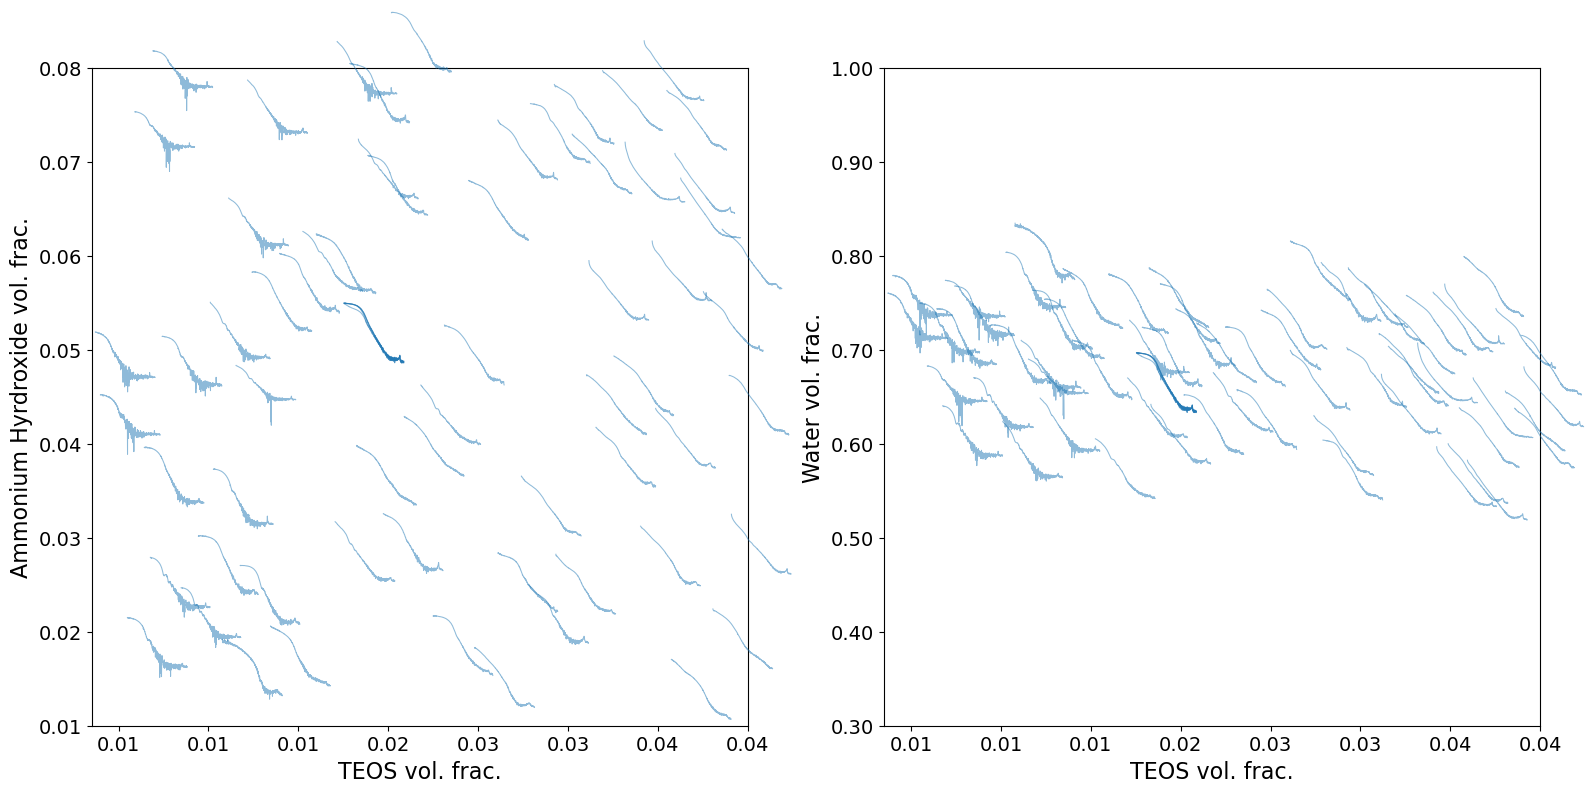

In [31]:
x_ind = 0
y_ind = 1

x_2_ind = 0
y_2_ind = 5


names = ['teos_vf', 'ammonia_vf', 'ethanol_vf', 'ctab_mass', 'F127_mass', 'water_vf']
labels = ['TEOS vol. frac.', 'Ammonium Hyrdroxide vol. frac.', 'Ethanol vol. frac.', 'CTAB mass', 'Pluronic F127 mass', 'Water vol. frac.']

x_name = names[x_ind]
y_name = names[y_ind]

x_2_name = names[x_2_ind]
y_2_name = names[y_2_ind]

x_min = lower_bounds[x_ind]
x_max = upper_bounds[x_ind]
y_min = lower_bounds[y_ind]
y_max = upper_bounds[y_ind]


x_2_min = lower_bounds[x_2_ind]
x_2_max = upper_bounds[x_2_ind]
y_2_min = lower_bounds[y_2_ind]
y_2_max = upper_bounds[y_2_ind]

bounds = np.array([[x_min, y_min], [x_max, y_max]])
bounds_2 = np.array([[x_2_min, y_2_min], [x_2_max, y_2_max]])

x_key = x_name
y_key = y_name

x_2_key = x_2_name
y_2_key = y_2_name



fig, ax = plt.subplots(1, 2, figsize = (16, 8))

c_1 = []
s = []
c_2 = []

colors_1 = []
colors_2 = []
for uuid_val, sample in sobolbatch_samples.items():

    x_val = sample['composition'][x_key]
    y_val = sample['composition'][y_key]

    x_2_val = sample['composition'][x_2_key]
    y_2_val = sample['composition'][y_2_key]

    I = np.log10(sample['data']['Intensity'])

    c_1.append([x_val, y_val])
    s.append(I)
    c_2.append([x_2_val, y_2_val])
    colors_1.append(get_colormap_color_monodispersity(sample['sample_name'], monodisperse_dispersion, monodisperse_aggregates, polydisperse_dispersion, polydisperse_aggregates, other))
    colors_2.append(get_colormap_color_aggregates(sample['sample_name'], monodisperse_dispersion, monodisperse_aggregates, polydisperse_dispersion, polydisperse_aggregates, other))

        

s = np.array(s)

pd_utils.plot_phasemap(bounds, ax[0], c_1, s)
pd_utils.plot_phasemap(bounds_2, ax[1], c_2, s)

ax[0].set_xlabel(f'{labels[x_ind]}', size = 16)
ax[0].set_ylabel(f'{labels[y_ind]}', size = 16)
ax[0].yaxis.set_major_formatter(FuncFormatter(format_func_0))
ax[0].xaxis.set_major_formatter(FuncFormatter(format_func_0))

ax[0].set_xlim([bounds[0][0], bounds[1][0]])
ax[0].set_ylim([bounds[0][1], bounds[1][1]])

ax[1].set_xlabel(f'{labels[x_2_ind]}', size = 16)
ax[1].set_ylabel(f'{labels[y_2_ind]}', size = 16)

ax[1].yaxis.set_major_formatter(FuncFormatter(format_func))
ax[1].xaxis.set_major_formatter(FuncFormatter(format_func))

ax[1].set_xlim([bounds_2[0][0], bounds_2[1][0]])
ax[1].set_ylim([bounds_2[0][1], bounds_2[1][1]])

ax[0].tick_params(axis='both', labelsize=14) 
ax[1].tick_params(axis='both', labelsize=14) 


plt.tight_layout()
plt.savefig('USAXS_phaseplots_ammoniawater.png', dpi = 300)


In [23]:
bounds_2

array([[ 10,   0],
       [100, 300]])

In [24]:
sample['composition']

{'teos_vf': np.float64(0.018174750509206205),
 'ammonia_vf': np.float64(0.06573025310412049),
 'water_vf': np.float64(0.5751282546459697),
 'ethanol_vf': np.float64(0.34096674174070357),
 'ctab_mass': np.float64(32.73015918210149),
 'F127_mass': np.float64(111.29422355443239)}

In [25]:
np.log10(sample['data']['Intensity'])

0      6.879619
1      6.758265
2      6.687931
3      6.607797
4      6.591508
         ...   
495   -1.253486
496   -1.263951
497   -1.230765
498   -1.415003
499   -1.374880
Name: Intensity, Length: 500, dtype: float64

In [26]:
s[0,0]

np.float64(4.51152686052816)

In [16]:
sobolbatch_samples

{'5dfdbe5e-3f38-44de-b9db-65c72c27f02e': {'sample_name': 'SobolBatch_control_1',
  'cartridge_number': 1.0,
  'cartridge_cell': 'A3',
  'data':      Qvector_A     Intensity   Uncertainty
  0     0.000253  32473.332587   1441.400121
  1     0.000262  31848.745324   4478.965097
  2     0.000267  31998.990795   9107.494474
  3     0.000271  31360.587261  11580.730803
  4     0.000276  31667.541185   9066.726254
  ..         ...           ...           ...
  495   0.282079      0.069746      0.002378
  496   0.285966      0.069326      0.002392
  497   0.289885      0.071608      0.002368
  498   0.293837      0.066692      0.002111
  499   0.297823      0.068964      0.001321
  
  [500 rows x 3 columns],
  'composition': {'teos_vf': np.float64(0.017380730715658967),
   'ammonia_vf': np.float64(0.04829034143863227),
   'water_vf': np.float64(0.6300414079040331),
   'ethanol_vf': np.float64(0.3042875199416756),
   'ctab_mass': np.float64(28.60770255),
   'F127_mass': np.float64(102.2299974)

## star plots

In [73]:
for tic in ax.get_xticklabels():
    print(tic)

Text(0.0, 0, '10.000')
Text(0.2, 0, '28.000')
Text(0.4, 0, '46.000')
Text(0.6000000000000001, 0, '64.000')
Text(0.8, 0, '82.000')
Text(1.0, 0, '100.000')


In [28]:
import pandas as pd
import numpy as np
from sklearn import manifold
from sklearn.metrics import euclidean_distances
seed = np.random.RandomState(seed=2050)
import itertools as it 
import matplotlib.pyplot as plt
# from matplotlib.colormaps import get_cmap
from matplotlib import cm
from matplotlib.colors import Normalize

In [29]:
def reduce(grid):
    similarities = euclidean_distances(grid)

    dim = 2
    max_iter = 6000
    eps = 1e-9
    mds = manifold.MDS(n_components=dim, 
                       max_iter=max_iter, 
                       eps=eps, 
                       random_state=seed,
                       dissimilarity='precomputed'
                       )
    print('Similarities have shape {}'.format(np.shape(similarities)))
    mds.fit(similarities)
    pos = mds.embedding_

    return pos

In [30]:
n = 10
inary = 5
el = np.array([i/n for i in range(n+1)])
grid = np.array([x for x in it.product(el, repeat=inary) if np.isclose(np.sum(x),1)])
corners = np.eye(inary)
pos_grid = reduce(grid)


Similarities have shape (1001, 1001)


In [31]:


from scipy.spatial.distance import cdist

def look_up_grid(x):
    dist = cdist(x.reshape(1,-1), grid)
    idx = np.argmin(dist)

    return pos_grid[idx,:]

corners = np.eye(inary)
pos_corners = np.asarray([look_up_grid(ci) for ci in corners])
pos_zero = look_up_grid(np.zeros(inary))



In [32]:
pos_zero

array([9.33544652e-05, 1.16772021e-03])

In [33]:
pos_corners

array([[-0.67801108, -0.60755204],
       [ 0.20162848,  0.8889203 ],
       [-0.79131574,  0.45133631],
       [ 0.3354758 , -0.84621714],
       [ 0.9098995 ,  0.04965776]])

## normalize composition data into range 0, 1

Leave out water for now

In [78]:
x = np.zeros((len(sobolbatch_samples), 5))

for i, sample in enumerate(sobolbatch_samples.values()):
    teos_norm = (sample['composition']['teos_vf'] - lower_bounds[0])/(upper_bounds[0] - lower_bounds[0])
    ammonia_norm = (sample['composition']['ammonia_vf'] - lower_bounds[1])/(upper_bounds[1] - lower_bounds[1])
    ethanol_norm = (sample['composition']['ethanol_vf'] - lower_bounds[2])/(upper_bounds[2] - lower_bounds[2])
    ctab_norm = (sample['composition']['ctab_mass'] - lower_bounds[3])/(upper_bounds[3] - lower_bounds[3])
    f127_norm = (sample['composition']['F127_mass'] - lower_bounds[4])/(upper_bounds[4] - lower_bounds[4])

    x[i,:] = [teos_norm, ammonia_norm, ethanol_norm, ctab_norm, f127_norm]

In [79]:
pos_data = np.asarray([look_up_grid(x[i,:]) for i in range(len(x))]) 

In [80]:
x_min = min(pos_data[:,0])
y_min = min(pos_data[:,1])

x_max = max(pos_data[:,0])
y_max = max(pos_data[:,1])

<function plot_phasemap.<locals>.<lambda> at 0x7f5d1764a8e0>


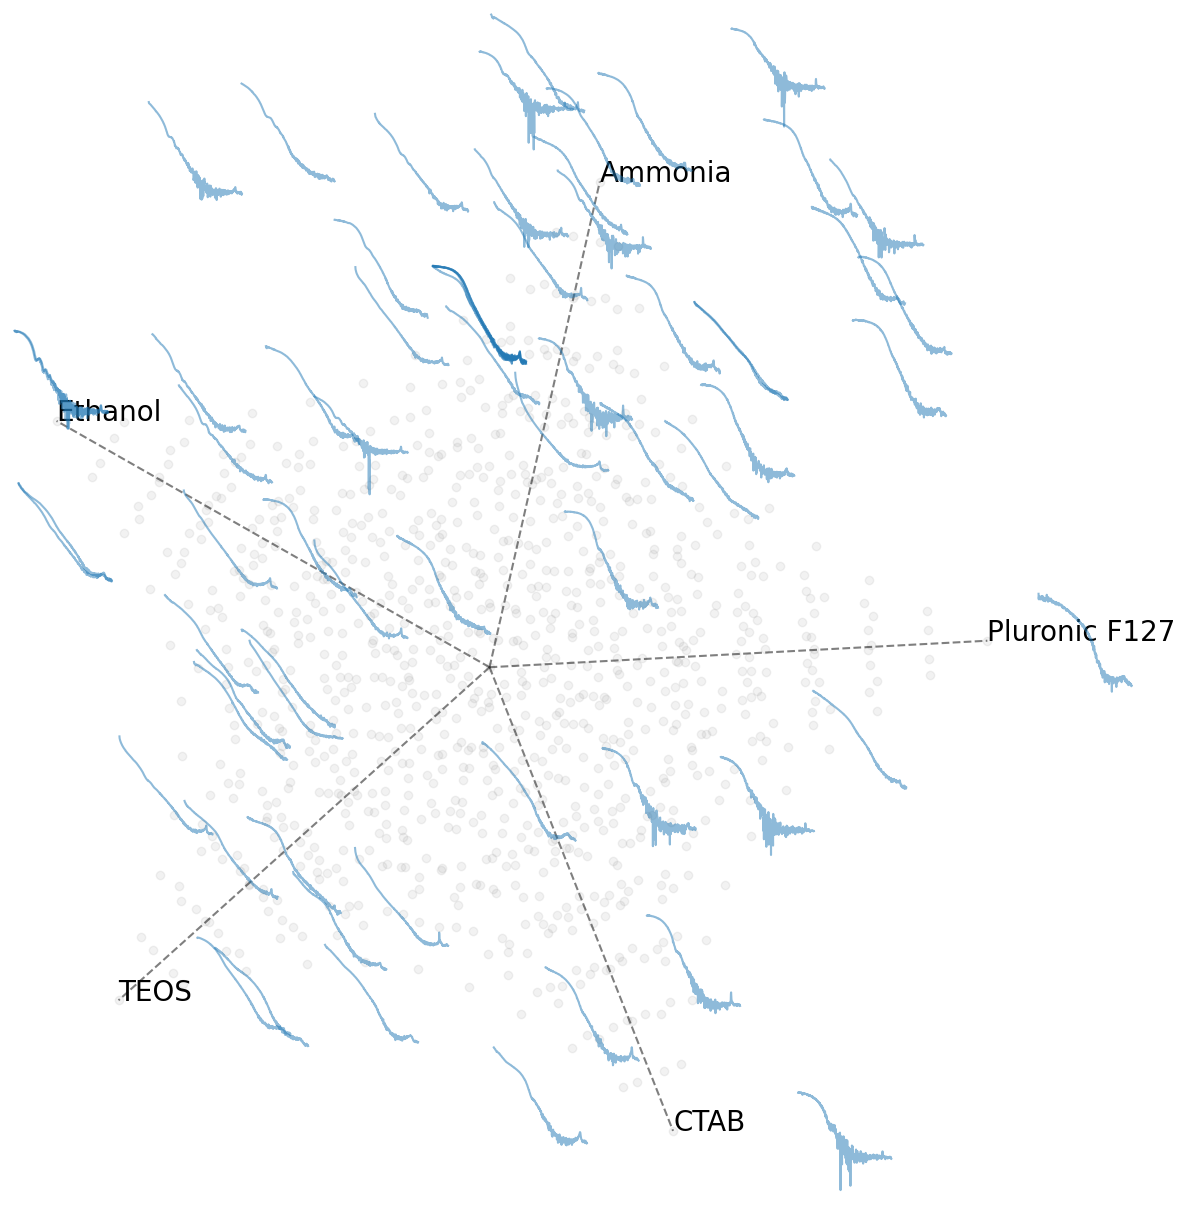

In [82]:
x_ind = 0
y_ind = 3


names = ['teos_vf', 'ammonia_vf', 'ethanol_vf', 'ctab_mass', 'F127_mass', 'water_vf']

# x_name = names[x_ind]
# y_name = names[y_ind]

# x_min = lower_bounds[x_ind]
# x_max = upper_bounds[x_ind]
# y_min = lower_bounds[y_ind]
# y_max = upper_bounds[y_ind]

# y_2_min = lower_bounds[1]
# y_2_max = upper_bounds[1]

bounds = np.array([[x_min, y_min], [x_max, y_max]])
#bounds_2 = np.array([[x_min, y_2_min], [x_max, y_2_max]])




fig, ax = plt.subplots(figsize = (12, 12))

c_1 = []
s = []
#c_2 = []

colors_1 = []
colors_2 = []
for i, (uuid_val, sample) in enumerate(sobolbatch_samples.items()):


    I = np.log10(sample['data']['Intensity'])
    s.append(I)

        

s = np.array(s)
c_1 = pos_data

pd_utils.plot_phasemap(bounds, ax, c_1, s)

axis_names = np.asarray(['TEOS', 'Ammonia', 'Ethanol', 'CTAB', 'Pluronic F127'])
for i, l in enumerate(axis_names):
        line = np.vstack((pos_zero, pos_corners[i,:]))
        ax.plot(line[:,0], line[:,1], color='k', alpha=0.5, linestyle='dashed')
        ax.text(pos_corners[i,0], pos_corners[i,1], l,
                color='k', fontsize=20)

ax.scatter(pos_grid[:,0],pos_grid[:,1], 
              color='grey', alpha=0.1)
ax.axis('equal')
ax.axis('off')

plt.tight_layout()
plt.savefig('starplot.png', dpi = 300)


In [65]:
x

array([[3.80293992e-01, 5.47004878e-01, 5.21437600e-01, 2.06752251e-01,
        3.40766658e-01],
       [3.80293992e-01, 5.47004878e-01, 5.21437600e-01, 2.06752251e-01,
        3.40766658e-01],
       [3.80293992e-01, 5.47004878e-01, 5.21437600e-01, 2.06752251e-01,
        3.40766658e-01],
       [7.00769235e-01, 8.79277512e-01, 3.19477640e-01, 1.81920875e-01,
        4.57316795e-02],
       [6.14915626e-01, 1.67432030e-01, 1.68895572e-02, 7.46829892e-02,
        1.33162917e-01],
       [7.53463294e-01, 6.11588888e-01, 5.45285724e-01, 5.05668495e-01,
        3.60016666e-01],
       [4.52512234e-01, 9.89082363e-01, 5.76759835e-01, 3.58850863e-02,
        4.14575546e-01],
       [1.81124882e-01, 2.94819222e-01, 1.10894200e-01, 6.06488402e-01,
        7.85735305e-02],
       [1.23142265e-03, 5.02895493e-01, 2.88941939e-01, 6.51594376e-01,
        2.41188070e-01],
       [3.66597645e-01, 2.14600080e-01, 7.74370131e-01, 2.05626647e-01,
        2.63709678e-01],
       [9.70650805e-01, 2.2603